# Bitcoin & Twitter

Project on Data Mining by Bontenakel Lenny & Bels Senne.  
 *[Link to our github repository](https://github.com/snenenenenenene/btc-twitter-data-mining)*

# Introduction

## Research Question

In this project we will research the correlation between the activity around cryptocurrency on social media and the actual stock price of said cryptocurrency. In this case we will take the examples of social media channel *Twitter* and the cryptocurrency *Bitcoin*.

To achieve this we ask ourselves the following question:

Is there a correlation between the activity and public sentiment on Twitter regarding Bitcoin and the stock price of Bitcoin?

## Hypothesis

Tweets have a measurable effect on the stock price of Bitcoin. 
Positive tweets affect the stocks positively, negative tweets do so negatively.

## Method

To answer this question we will look and analyze at past data from Kaggle.com and Yahoo Finance. By analyzing this data we can easily formulate the answer to our question.

## Technologies

Name       | Reason
-----------|--------------------------------
PySpark    | Loading and processing datasets
Matplotlib | Visualising data
Pattern    | Analysing sentiments
Folium     | Mapping locations on a map

In [1]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import *
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
import re
import datetime
from typing import List
import numpy as np
from wordcloud import WordCloud
import folium
from PIL import Image
import yfinance as yf
from geopy.geocoders import Nominatim
from pattern.en import sentiment
from pyspark.sql import functions as F
from pyspark.sql.functions import col, desc, asc, udf, max, struct
try:
    sc = SparkContext("local").getOrCreate()
except:
    print("Spark Context Initialised")

sqlContext = SQLContext(sc)
spark = SparkSession(sc)
plt.style.use('ggplot')

spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/14 20:56:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Tweets

We load tweet data from a dataset found on kaggle. A link to this dataset can be found in the README, provided in our *[github repository](https://github.com/snenenenenenene/btc-twitter-data-mining)*.   
This dataset contains all tweets with some regard or mention of Bitcoin. This could be a hashtag or simply any mention of Bitcoin within the text of the tweet.

The dataset contains following data:


Column           | Description
-----------------|------------------------------------------------------------------------------------------
user_name        | The name of the user, as they’ve defined it.
user_location    | The user-defined location for this account’s profile.
user_description | The user-defined UTF-8 string describing their account.
user_created     | Time and date, when the account was created.
user_followers   | The number of followers an account currently has.
user_friends     | The number of friends a account currently has.
user_favourites  | The number of favorites a account currently has
user_verified    | When true, indicates that the user has a verified account
date             | UTC time and date when the Tweet was created
text             | The actual UTF-8 text of the Tweet
hashtags         | All the other hashtags posted in the tweet along with #Bitcoin & #btc
source           | Utility used to post the Tweet, Tweets from the Twitter website have a source value - web
is_retweet       | Indicates whether this Tweet has been Retweeted by the authenticating user.

In [2]:
tweets_schema = StructType([
    StructField('user_name', StringType(), True),
    StructField('user_location', StringType(), True),
    StructField('user_description', StringType(), True),
    StructField('user_created', StringType(), True),
    StructField('user_followers', FloatType(), True),
    StructField('user_friends', FloatType(), True),
    StructField('user_favourites', FloatType(), True),
    StructField('user_verified', BooleanType(), True),
    StructField('date', StringType(), True),
    StructField('text', StringType(), True),
    StructField('hashtags', StringType(), True),
    StructField('source', StringType(), True),
    StructField('is_retweet', BooleanType(), True),
])

tweets_df = spark.read.csv(
    "./data/tweets.csv",
    header=True,
    sep=',',
    multiLine=True,
    escape="\"",
    unescapedQuoteHandling="STOP_AT_CLOSING_QUOTE",
    schema=tweets_schema
)

tweets_df = tweets_df.withColumn("date", F.to_date(F.col("date")))
tweets_df

user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
DeSota Wilson,"Atlanta, GA","Biz Consultant, r...",2009-04-26 20:05:09,8534.0,7605.0,4838.0,false,2021-02-10,Blue Ridge Bank s...,['bitcoin'],Twitter Web App,false
CryptoND,null,😎 BITCOINLIVE is...,2019-10-17 20:12:10,6769.0,1532.0,25483.0,false,2021-02-10,"😎 Today, that's ...","['Thursday', 'Btc...",Twitter for Android,false
Tdlmatias,"London, England",IM Academy : The ...,2014-11-10 10:50:37,128.0,332.0,924.0,false,2021-02-10,"Guys evening, I h...",null,Twitter Web App,false
Crypto is the future,null,I will post a lot...,2019-09-28 16:48:12,625.0,129.0,14.0,false,2021-02-10,$BTC A big chance...,"['Bitcoin', 'FX',...",dlvr.it,false
Alex Kirchmaier ?...,Europa,Co-founder @RENJE...,2016-02-03 13:15:55,1249.0,1472.0,10482.0,false,2021-02-10,This network is s...,['BTC'],Twitter Web App,false
ZerrBenz™ ⚔ ✪ 20732,"Bkk, Thailand",I'm a cat slave ?...,2010-01-12 07:00:04,742.0,716.0,2444.0,false,2021-02-10,💹 Trade #Crypto ...,"['Crypto', 'Binan...",Twitter Web App,false
Bitcoin-Bot,"Florida, USA",Bot to generate B...,2019-12-23 16:49:16,131.0,84.0,5728.0,false,2021-02-10,&lt;'fire' &amp; ...,"['Bitcoin', 'Cryp...",BTC_p_bot,false
Cryptocurrencies ...,null,Stay updated on t...,2018-08-03 21:30:08,4052.0,1.0,9.0,false,2021-02-10,🔄 Prices update ...,null,Cryptocurrencies ...,false
Mikcoin,null,Technical Analyst...,2020-11-26 23:45:46,104.0,41.0,238.0,false,2021-02-10,#BTC #Bitcoin #Et...,"['BTC', 'Bitcoin'...",Twitter Web App,false
DeSota Wilson,"Atlanta, GA","Biz Consultant, r...",2009-04-26 20:05:09,8534.0,7605.0,4838.0,false,2021-02-10,.@Tesla’s #bitcoi...,"['bitcoin', 'cryp...",Twitter Web App,false


# Yahoo finance data

We also require a dataset with the stock price of Bitcoin over the period between 26-11-2021 and 5-2-2021. For this we will use the Yahoo Finance library. The data we get from this looks like this:


Column       | Description
-------------|-------------------------------------------------------
Open         | Open value of the currency
High         | Highest value of currency in the given minute
Low          | Lowest value of currency in the given minute
Close        | Close value of the currency in the given minute
Volume       | Volume of the currency transacted in the given minute.
Dividends    | ...
Stock Splits | ...

In [3]:
btc_stock = yf.Ticker("BTC-USD")
end = datetime.datetime(2021, 11, 26)
start = datetime.datetime(2021, 2, 5)

btc_stock = btc_stock.history(start=start, end=end)
btc_stock = btc_stock.reset_index()

btc_df = spark.createDataFrame(btc_stock)
btc_df

Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
2021-02-04 00:00:00,37475.10546875,38592.17578125,36317.5,36926.06640625,68838074392,0,0
2021-02-05 00:00:00,36931.546875,38225.90625,36658.76171875,38144.30859375,58598066402,0,0
2021-02-06 00:00:00,38138.38671875,40846.546875,38138.38671875,39266.01171875,71326033653,0,0
2021-02-07 00:00:00,39250.19140625,39621.8359375,37446.15234375,38903.44140625,65500641143,0,0
2021-02-08 00:00:00,38886.828125,46203.9296875,38076.32421875,46196.46484375,101467222687,0,0
2021-02-09 00:00:00,46184.9921875,48003.72265625,45166.9609375,46481.10546875,91809846886,0,0
2021-02-10 00:00:00,46469.76171875,47145.56640625,43881.15234375,44918.18359375,87301089896,0,0
2021-02-11 00:00:00,44898.7109375,48463.46875,44187.76171875,47909.33203125,81388911810,0,0
2021-02-12 00:00:00,47877.03515625,48745.734375,46424.9765625,47504.8515625,76555041196,0,0
2021-02-13 00:00:00,47491.203125,48047.74609375,46392.28125,47105.515625,70250456155,0,0


# Dataset Quality

## Missing values

After having loaded our datasets we need to analyze the quality of our dataset. For this we will take a look at the amount of missing values in our dataset.    
The locations of users should however be tolerated. Missing data in this column is not due to a low quality dataset, but due to some users not being willing to share their locations. Which should of course be respected and tolerated. Thus, there will be no actions taken to fill in this data.  
The red horizontal baseline indicates the total amount of rows present in the dataset.

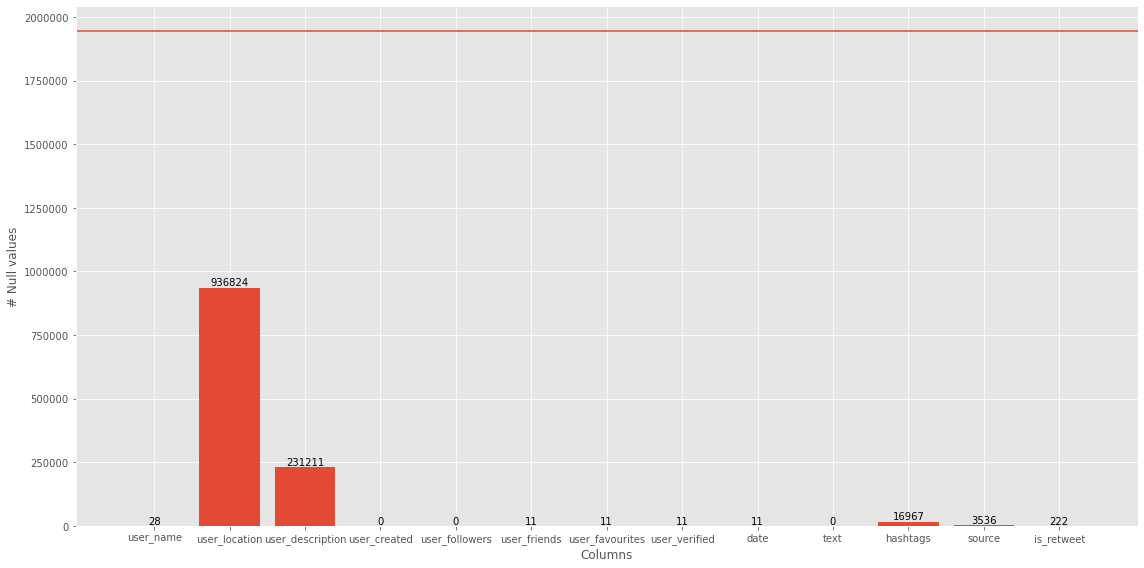

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.axhline(y=tweets_df.count(), label="Total amount of rows")
ax.bar_label(
    ax.bar(
        tweets_df.columns,
        [tweets_df.where(col(l).isNull()).count() for l in tweets_df.columns]
    )
)

ax.set_xlabel("Columns")
ax.set_ylabel("# Null values")

ax.ticklabel_format(axis='y', style='plain')
fig.tight_layout()
plt.show()

## Date Histogram

An important aspect of our data is the equal distribution of the dates. This way it's simple to superimpose the tweets with the Bitcoin values. 

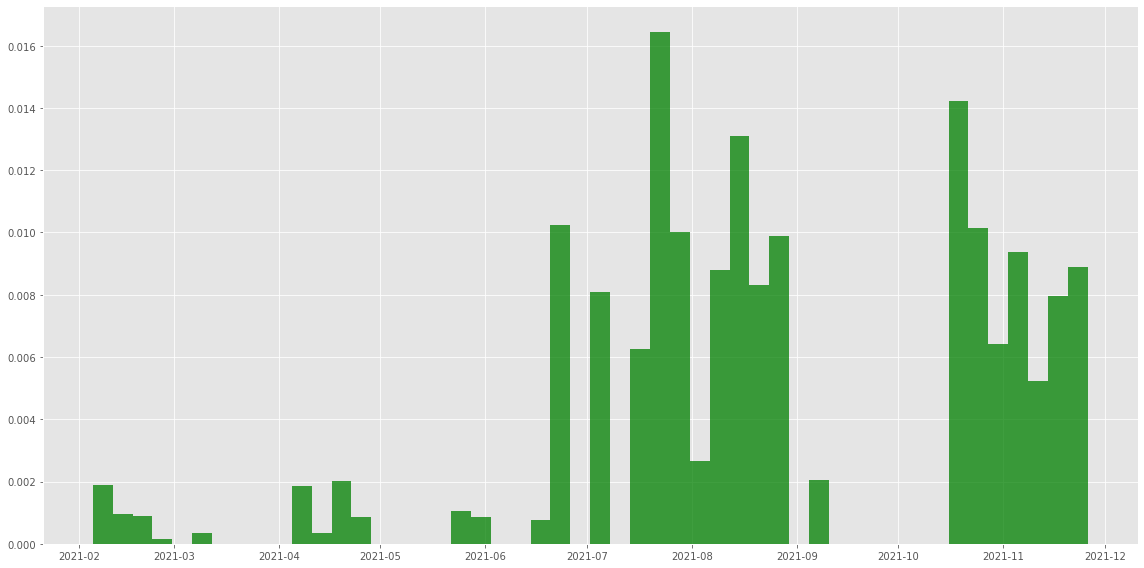

In [5]:
tweet_dates = tweets_df.select("date").collect()
tweet_dates = list(map(lambda r: r['date'], tweet_dates))
tweet_dates

plt.figure(figsize=(16, 8))
plt.hist(tweet_dates, 50, density=True, facecolor='g', alpha=0.75)
plt.tight_layout()
plt.show()

Sadly this is not the case however. The tweets are mysteriously not spread out evenly. The cause for this is not simple to determine and the occurance is quite odd. As it is very unlikely a day passes by without someone posting a tweet on Bitcoin. And as we can see there are only very little values missing from this column. So the answer to this mystery will need to be answered by the maintainer of this dataset.

However, as the rest of this dataset is quite qualitative. We will continue using this dataset throughout this project. Though we will have to keep in mind that a few date entries are missing here.

# Data Preprocessing

With the data loaded and checked. Not all of it is clean and ready to be used. Frankly, a data mining project wouldn't be complete without some data preprocessing. Thus there need to be some operations performed to make the data usable for our analysis. 

## Text cleaning

Not all text in our dataset is clean and some of it needs to be cleant for it to be used. Hyperlinks and newline characters for example interfere with the capabilities of PySpark and might cause a crash whenever we try to use it. 

In [6]:
def clean_text(text):
    if (isinstance(text, str)):
        text = text.replace("#", "")
        text = re.sub('\\n', '', text)
        text = re.sub('https:\/\/\S+', '', text)
        return text
    else:
        return ""
clean_text_udf = udf(lambda x: clean_text(x), StringType())

tweets_df = tweets_df.withColumn("text", clean_text_udf(col("text"))).dropna(subset=["user_name"])

## Fixing the hashtags array column 
Before we can generate the impact score, we need to generate an array of strings. This array represents the hashtags present within the tweet.
Since the csv format - which we use to read in the data - does not support arrays in pyspark. We need to fix it after reading it in as a string.

In [7]:
def fix_hashtags_array(hashtags_arr_string):
    try:
        closing_bracket = hashtags_arr_string.index(']', 1)
        subject = hashtags_arr_string[1 :closing_bracket]

        result = subject.split(', ') if closing_bracket > 1 else []
        result = ' '.join(result).replace("'", "").split()

        return result
        
    except ValueError:
        return []
    
fix_hashtags_array_udf = udf(lambda x: fix_hashtags_array(x), ArrayType(StringType()))

tweets_df = tweets_df.fillna("[]", subset="hashtags").withColumn("hashtags", fix_hashtags_array_udf(col("hashtags")))

## Generating Date Dataframe

At this moment we are lacking the column in our Yahoo Finance dataset containing the dates of every Bitcoin stock price. However, we do know the first and last date of the dataset - namely 5-2-2021 and 26-11-2021 - as well as the fact that this data registers new entries at regular intervals. With this knowledge we could generate a date dataframe. 

In [8]:
tweets_df = tweets_df.withColumn("date", F.to_date(F.col("date")))
date_df = tweets_df
date_df = date_df.groupby("date").count().dropna().sort(asc("date")).filter(
    (date_df.date > datetime.datetime(2020, 3, 20)) & (date_df.date < datetime.datetime.today()))

counts_df = date_df

def _get_next_dates(start_date: datetime.date, diff: int) -> List[datetime.date]:
    return [start_date + datetime.timedelta(days=days) for days in range(1, diff)]

def _get_fill_dates_df(df: DataFrame, date_column: str, group_columns: List[str], fill_column: str) -> DataFrame:
    get_next_dates_udf = udf(_get_next_dates, ArrayType(DateType()))

    window = Window.orderBy(*group_columns, date_column)

    return df.withColumn("_diff", F.datediff(F.lead(date_column, 1).over(window), date_column)).filter(col("_diff") > 1).withColumn("_next_dates", get_next_dates_udf(date_column, "_diff")).withColumn(fill_column, F.lit('')).withColumn(date_column, F.explode("_next_dates")).drop("_diff", "_next_dates")

fill_df = _get_fill_dates_df(date_df, "date",[], "count")
date_df = date_df.union(fill_df).sort(asc(col("date")))

# Data Visualisation

## Most popular users

We will start separating data from the main dataframe, to create a new dataframe showing data about the used accounts.
This way we can easily show what accounts are most followed and loved.
However, user accounts are constantly changing. The amounts of followers, friends and favourites an account has rarely remains the same for long.
These values rise and fall, therefore it would not be wise to simply select the instance with the max amount of followers.

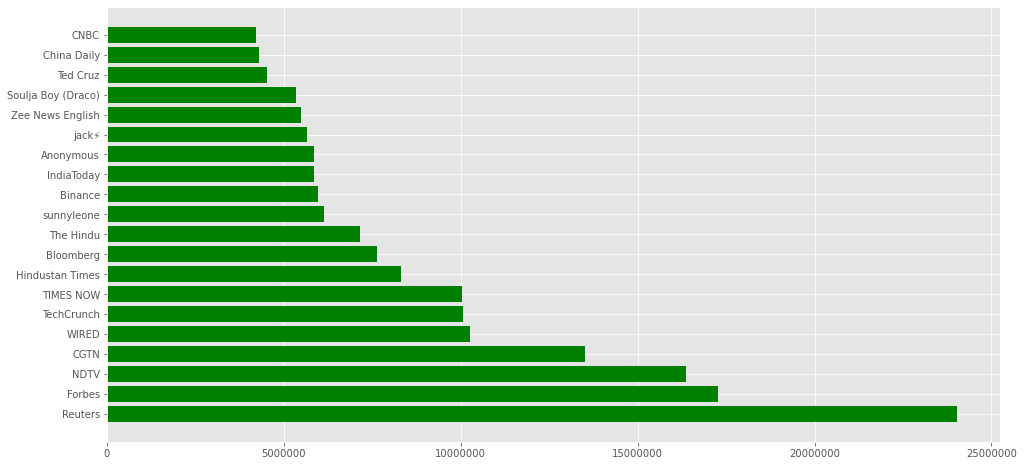

In [9]:
accounts_df = tweets_df.groupBy('user_name').max('user_followers').withColumnRenamed('max(user_followers)', 'user_followers').sort(desc('user_followers'))

x_rows = accounts_df.select('user_name').collect()
y_rows = accounts_df.select('user_followers').collect()

fig, ax = plt.subplots(figsize=(16, 8))

n = 20
ax.barh(
    [x.user_name for x in x_rows[:n]],
    [y.user_followers for y in y_rows[:n]],
    color='green',
    label='tweets/ user'
)

ax.ticklabel_format(axis='x', style='plain')
plt.show()

## Most active user

We will also look at the 10 most active users in the dataset.

Text(0, 0.5, 'username')

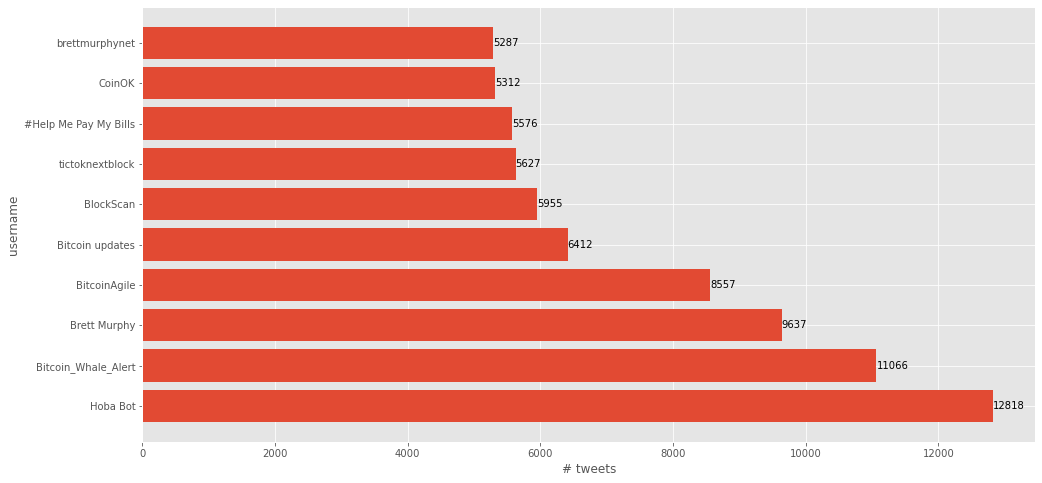

In [10]:
%matplotlib inline

user_volume = tweets_df.groupby("user_name").count().withColumnRenamed("count", "user_count").sort(desc("user_count"))

n = 10
x_rows = user_volume.limit(n).select("user_name").collect()
y_rows = user_volume.limit(n).select("user_count").collect()

fig, ax = plt.subplots(figsize=(16, 8))

ax.bar_label(
    ax.barh([x.user_name for x in x_rows],
           [y.user_count for y in y_rows],
           label='tweets/ user')
)

ax.set_xlabel('# tweets')
ax.set_ylabel('username')

## Most occuring words

We can also take a look at the most recurring words. 
For the sake of not cluttering the wordcloud with futile words such as 'a', 'in' or 'and' we left out the aforementioned ones as well as a short - yet cherry-picked - list of others.

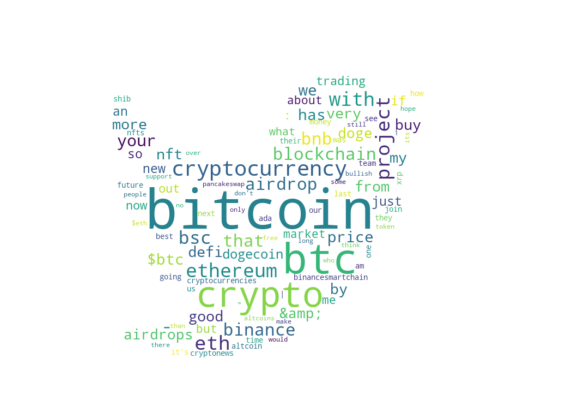

In [11]:
word_occurance = tweets_df.withColumn('word', F.explode(F.split(F.col('text'), ' '))).withColumn("word", F.lower("word")).groupBy('word').count().sort('count', ascending=False).where(
    "word not in (' ', '', 'the', 'a', 'to', 'and', 'a', 'in', 'of', 'for', 'you', 'will', 'be', 'on', 'this', 'i', 'The', 'are', 'at', 'it', 'I', 'like', 'can', 'or', 'go', 'up', 'is', 'not', 'do', 'have', 'get', 'as', 'when', 'all', 'been', 'great', 'up')").limit(100)

twitter_mask = np.array(Image.open('twitter.jpeg'))
freqs = {r.asDict()['word'] : r.asDict()['count'] for r in word_occurance.collect()}
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", mask=twitter_mask).generate_from_frequencies(freqs)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Most occuring hashtags

Another interesting piece of information is the most recurring hashtags

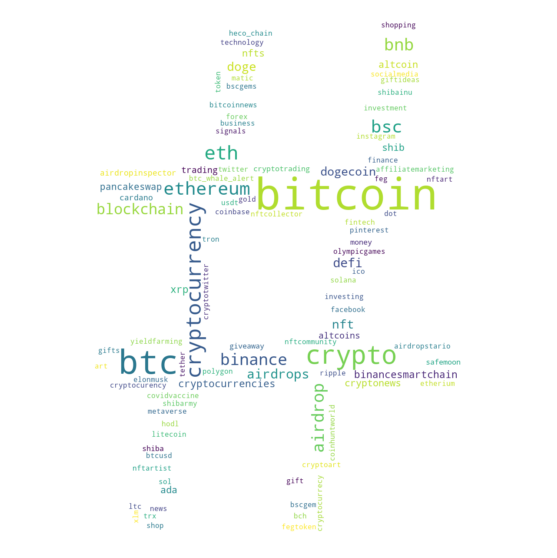

In [12]:
hashtags_occurance = tweets_df.select("hashtags").withColumn("hashtag", F.explode(col('hashtags'))).withColumn("hashtag", F.lower("hashtag")).groupBy('hashtag').count().sort(desc('count')).limit(100)

hashtag_mask = np.array(Image.open('hashtag.jpeg'))
freqs = {r.asDict()['hashtag'] : r.asDict()['count'] for r in hashtags_occurance.collect()}
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", mask=hashtag_mask).generate_from_frequencies(freqs)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
# plt.imshow(hashtag_mask)
plt.axis("off")
plt.show()

## Locations of users

We're also interested in the locations of users. This does not really aid us in answering our question. But nevertheless it's fun to look at.

In [13]:
# df_location = tweets_df.groupBy('user_location').count().sort(col("count").desc()).show()

geolocator = Nominatim(user_agent="example")
location_df = tweets_df.groupBy('user_location').count().filter("count" >= x).where(
    "user_location not in ('Decentralized', 'Moon', '🇦🇺', 'Everywhere', 'Road Warrior', 'Mars', 'Cloud Engineer', 'Planet Earth', 'Earth', 'Blockchain', 'The Blockchain')").sort(
    col("count").desc()).dropna().collect()


def coords(location_string):
    try:
        location_obj = geolocator.geocode(location_string).raw
        return (location_obj['lat'], location_obj['lon'])
    except:
        return (20, 20)


locations = list(map(lambda r: [r['user_location'], r['count'], coords(r['user_location'])], location_df))
map_tweets = folium.Map(location=[51,10], zoom_start=2)

for location_name, count, location_coords in locations:
    folium.Circle(location=location_coords,
                  popup=f"{location_name}: {count}",
                  radius=count * 50,
                  color="crimson",
                  fill_color="crimson",
                  tooltip=count).add_to(map_tweets)
map_tweets

## Correlation between amount of tweets and Bitcoin stock price

It is then time to take a first poke at our research question. It may be a fairly naive and brute force way to do it, but it provides a decent initial insight in the answer to our research question. 

21/12/14 21:00:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/12/14 21:00:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/12/14 21:00:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/12/14 21:00:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/12/14 21:00:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


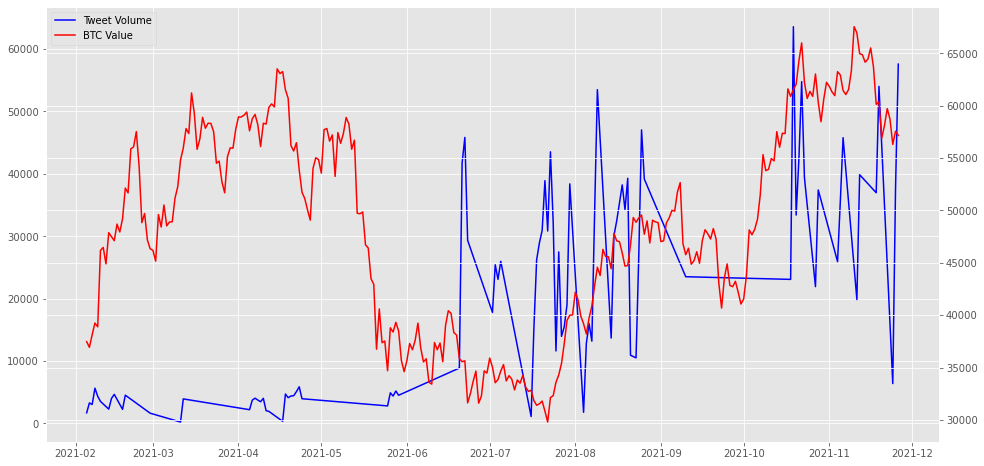

In [14]:
# X FOR BTC VOLUME
dates = date_df.select("date").collect()
x = list(map(lambda r: (r['date']), dates))

# X FOR COUNTS
counts_dates = counts_df.select("date").collect()
counts_x = list(map(lambda r: (r['date']), counts_dates))

# Y/COUNT OF TWEETS
y_rows = counts_df.select("count").collect()
tweets_y = list(map(lambda r: r['count'], y_rows))

# Y FOR BTC VOLUME
y_rows = btc_df.select("Open").collect()
btc_y = list(map(lambda r: float(r['Open']), y_rows))

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(counts_dates, tweets_y, color='blue', label='Tweet Volume')
# ax.set_yscale('log')
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2.plot(x,btc_y, color='red', label='BTC Value')
# ax2.set_yscale('log')
ax2.tick_params(axis='y')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2 , labels + labels2, loc=0)
plt.show()


## Sentiment Analysis

Of course, not every tweet is the same. It would be naive to conclude our research here. As every tweet carries a different sentiment. There are tweets which speak poorly of Bitcoin and others which praise Bitcoin as our ticket to the future. There are also the occasional bots which are tasked with spamming Twitter with the latest news and data. And these of course carry no sentiment at all.  

21/12/14 21:03:52 WARN TaskSetManager: Stage 122 contains a task of very large size (178852 KiB). The maximum recommended task size is 1000 KiB.
21/12/14 21:03:55 WARN TaskSetManager: Stage 125 contains a task of very large size (178852 KiB). The maximum recommended task size is 1000 KiB.


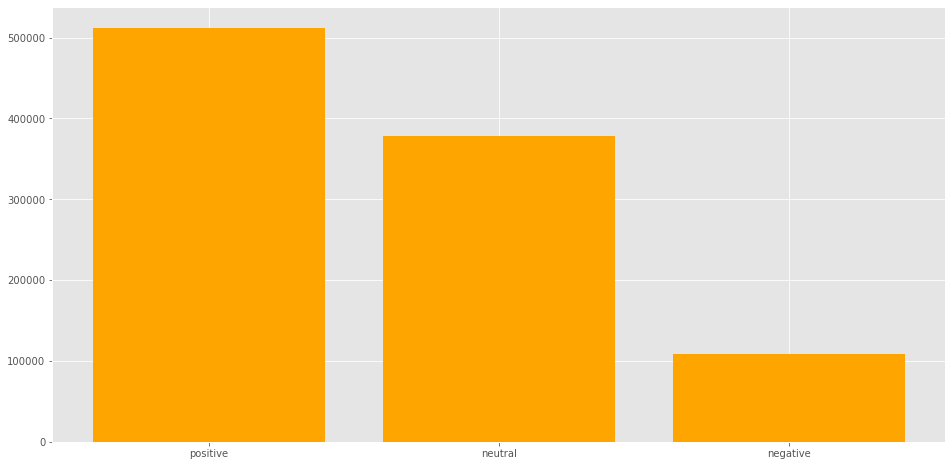

In [15]:
tweet_text = tweets_df.select("text", "date").limit(1000000).collect()
sentiments = [(x.text, *sentiment(x.text), x.date) for x in tweet_text]
sentiment_schema = StructType([
    StructField('text', StringType(), True),
    StructField('polarity', FloatType(), True),
    StructField('subjectivity', FloatType(), True),
    StructField('date', DateType(), True),
])

sentiments_df = spark.createDataFrame(
    data=sentiments,
    schema=sentiment_schema
)

def getSentiment(score):
    if score < 0:
        return "negative"
    elif score == 0:
        return "neutral"
    else:
        return "positive"

sentiment_value_udf = udf(lambda x: getSentiment(x), StringType())
sentiments_string_df = sentiments_df.withColumn("polarity", sentiment_value_udf(col("polarity")))

polarity_count = sentiments_string_df.select('polarity').groupBy('polarity').count()

polarity = polarity_count.select("polarity").collect()
x = list(map(lambda r: (r['polarity']), polarity))

count = polarity_count.select("count").collect()
y = list(map(lambda r: int(r['count']), count))

plt.subplots(figsize=(16, 8))
plt.bar(x,y, color='orange', label='Polarity Frequency')
plt.show()

21/12/14 21:03:58 WARN TaskSetManager: Stage 128 contains a task of very large size (178852 KiB). The maximum recommended task size is 1000 KiB.
21/12/14 21:04:02 WARN TaskSetManager: Stage 136 contains a task of very large size (178852 KiB). The maximum recommended task size is 1000 KiB.
21/12/14 21:04:06 WARN TaskSetManager: Stage 144 contains a task of very large size (178852 KiB). The maximum recommended task size is 1000 KiB.
21/12/14 21:04:10 WARN TaskSetManager: Stage 152 contains a task of very large size (178852 KiB). The maximum recommended task size is 1000 KiB.


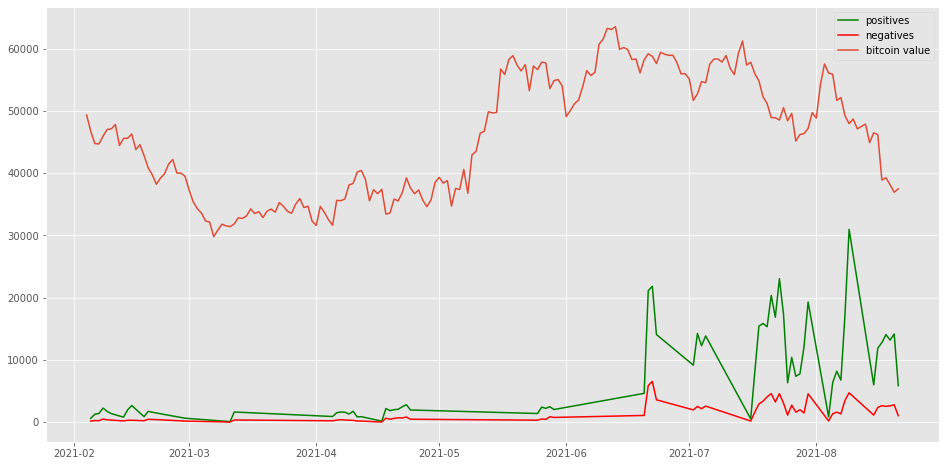

In [16]:
fig, ax = plt.subplots(figsize=(16, 8))

sentiments_string_df = sentiments_string_df.dropna(subset="date")

dates = sentiments_string_df.select("date").distinct().sort(desc("date")).collect()

positives = sentiments_string_df.where(col("polarity") == "positive").groupby("date").count().sort(desc("date")).select("count").collect()
ax.plot(dates, positives, color="green", label="positives")

# neutrals = sentiments_string_df.where(col("polarity") == "neutral").groupby("date").count().sort(desc("date")).select("count").collect()
# ax.plot(dates, neutrals, label="neutrals")

negatives = sentiments_string_df.where(col("polarity") == "negative").groupby("date").count().sort(desc("date")).select("count").collect()
ax.plot(dates, negatives, color="red", label="negatives")

date_limit = sentiments_string_df.agg({"date": "max"}).collect()[0]
date_limit = date_limit["max(date)"]

bitcoin_value = btc_df.select("Open").where(col("date") <= F.to_date(F.lit(date_limit))).collect()

btc_dates = btc_df.select("date").distinct().where(col("date") <= F.to_date(F.lit(date_limit))).sort(desc("date")).collect()

ax.plot(btc_dates, bitcoin_value, label="bitcoin value")
# ax.set_yscale("log")

ax.legend()
plt.show()

Despite a few missing dates in the tweets dataset, we can still determine a general outline of a plot. Starting from around May 2021 there was a steep rise in the value of BTC stock which continued for a few weeks. It then remained relatively stable until around August 2021. Where it started sinking back to the value it was in May 2021. We can see this same trend in the Twitter activity. Before this sudden rise of BTC stock value in May, the Twitter activity is very low. But after this sudden rise, the tweet activity rises with it. Though we see these trends do not align perfectly. The rise in Twitter activity follows the rise of BTC stock Value. 

# Conclusion

Looking at these plots we can bring forth a conclusion to our research question and hypothesis. It turns out to be quite a twist, it was in fact the opposite of what we expected. 
We find that the amount of tweets, whether they be positive or negative, does not stimulate the value of Bitcoin. As a matter of fact, **Bitcoin** stocks **influence** the **amount** of positive/negative tweets.
**HOWEVER**, we can not in good conscience put this conclusion in stone as this is based off of a small amount of usable data.

## Challenges during the project

As we stated many times during the various feedback moments. We struggled a lot with PySpark's method of reading and loading in .csv files. Looking at our data we can see it does not behave the same way as other well-known programs such as pandas.
 Slowly but steadily we made more progress in this regard. Nevertheless, we did not succeed in achieving this desired behaviour.
 The main "victim" of the out-of-the-box PySpark CSV reading method was the "date" column. This turned out to be especially detrimental as we started plotting the different sentiments. This, because the CSV loading was *skewed* to put it bluntly. This can be concluded because the hashtag column leaked into the date column. 
 It is hard to pin-point the culprit as the dataset wasn't 100% usable or "pure" to begin with.